In [1]:
# experimental run that takes two images + transformation matrix + 3D coordinate
# will only run on config_lego_rotation

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import tensorflow as tf
import numpy as np
from scipy import sparse
import imageio
import json
import random
import time

from utils.run_nerf_helpers import *
from utils.config_parser import config_parser
from utils.load_llff import load_llff_data
from utils.load_deepvoxels import load_dv_data
from utils.load_blender import load_blender_data
from utils.load_shapenet import load_shapenet_data
from utils.load_stanford_car import load_stanford_car

from model.embedder import *
from model.models import *

tf.compat.v1.enable_eager_execution()

args = None
NEAR = 0.
FAR = 1.5

from run_nerf_r import batchify, compute_features, run_network, create_nerf, render_rays, render, render_path


ID 0: 00166.jpg:


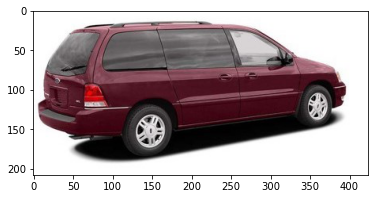

ID 1: 00022.jpg:


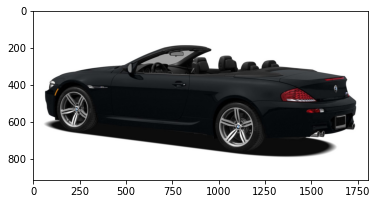

ID 2: 00062.jpg:


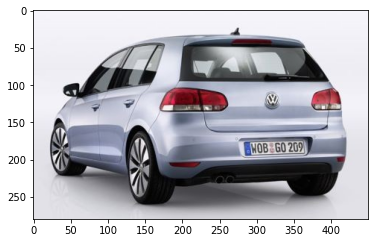

ID 3: 00076.jpg:


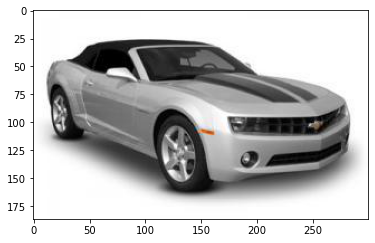

ID 4: 00146.jpg:


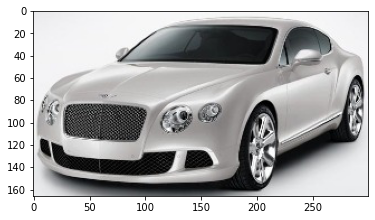

ID 5: 00169.jpg:


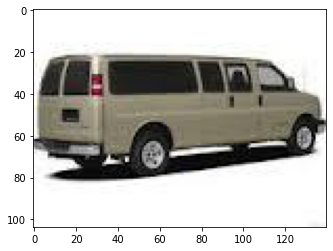

ID 6: 00178.jpg:


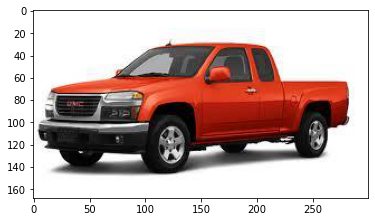

ID 7: 00348.jpg:


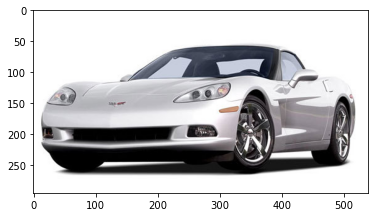

ID 8: 00472.jpg:


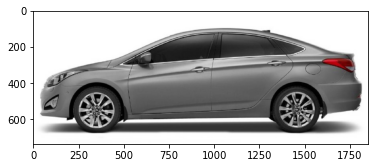

ID 9: 00475.jpg:


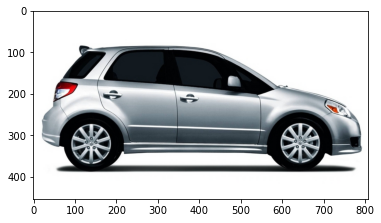

ID 10: 00748.jpg:


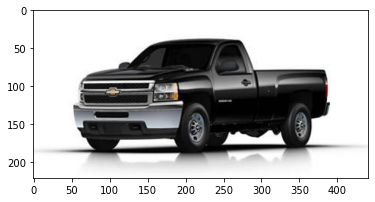

ID 11: 097500_obj_0_ground_truth.png:


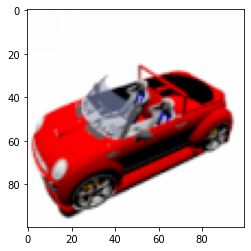

ID 12: 200000_ground_truth_val.png:


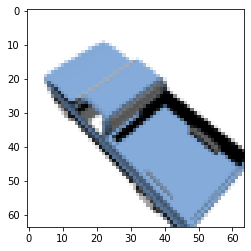

ID 13: blender-005652.color.png:


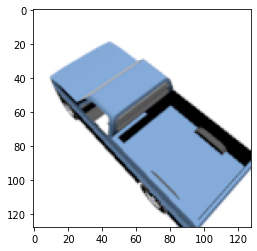

ID 14: 01066.jpg:


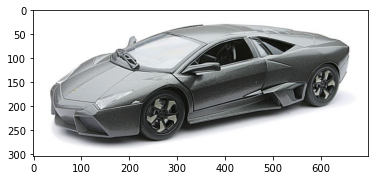

ID 15: 00563.jpg:


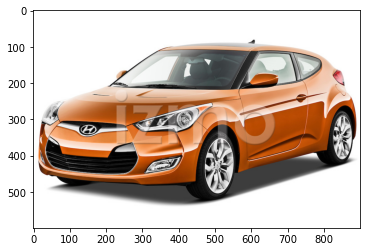

ID 16: 00896.jpg:


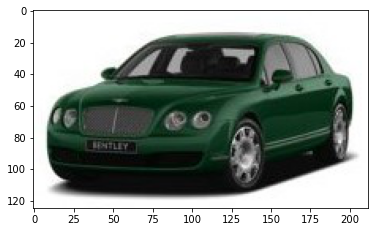

ID 17: 00949.jpg:


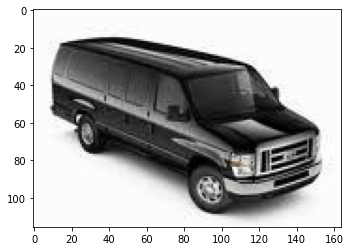

ID 18: blender-005643.color.png:


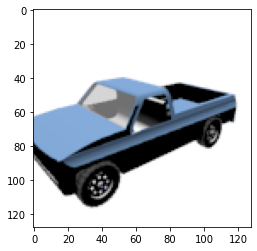

ID 19: filtered_00881.jpg:


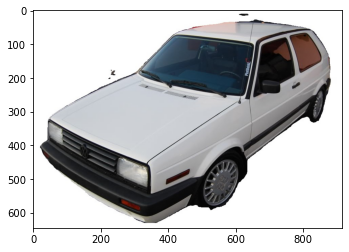

ID 20: filtered_00034.jpg:


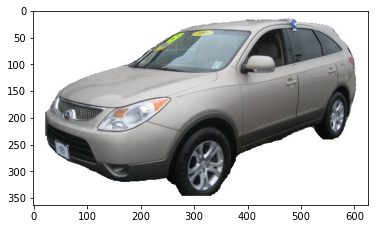

ID 21: filtered_00018.jpg:


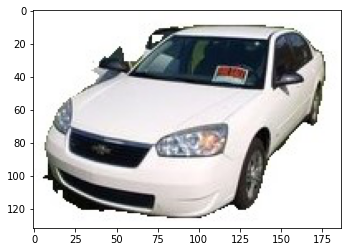

ID 22: filtered_00002.jpg:


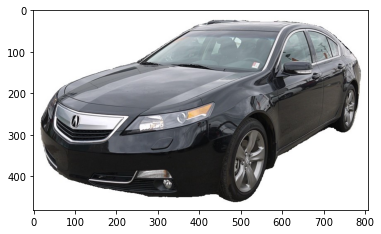

ID 23: filtered_00376.jpg:


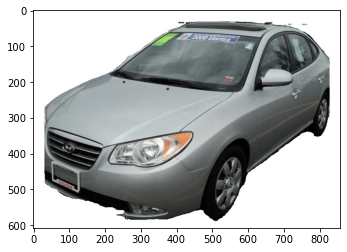

In [13]:
import pdb
from utils.load_stanford_car import *
from IPython.display import Video
import matplotlib.pyplot as plt

imgs_dir = './data/stanford_car_cropped/'

img_names = [name for name in os.listdir(imgs_dir) if name.endswith('.jpg') or name.endswith('.png')]

for i,img_name in enumerate(img_names):
    print(f'ID {i}: {img_name}:')
    plt.imshow(imageio.imread(os.path.join(imgs_dir,img_name)))
    plt.show()

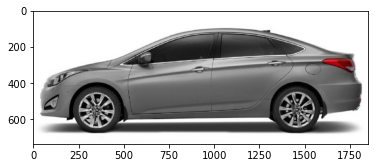

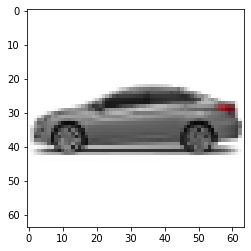

In [7]:
##### --------------setting--------------
parser = config_parser()
args = parser.parse_args("--config configs/config_car_full_global_local_render_real.txt")

IMG_ID = 8

H = W = 64
focal = 105  
near = 0
far = 1.5

hwf = [H, W, focal]

#-------------------------------------

def load_images(IMG_ID):
    rendering_name = os.path.join(imgs_dir,img_names[IMG_ID])

    images = []
    img = imageio.imread(rendering_name).astype('float32') / 255

    # pad to square image
    img_H, img_W = img.shape[:2]
    img_size = max([img_H,img_W])

    square_img = np.ones((img_size, img_size, 3)).astype('float32')
    diff_H = (img_size - img_H) // 2
    diff_W = (img_size - img_W) // 2
    square_img[diff_H: img_H + diff_H,diff_W: img_W + diff_W, :] = img

    # resize
    square_img = tf.image.resize_area(square_img[None,...], [H, W]).numpy()
    # apply Gaussian blur
    # square_img = gaussian_filter(square_img[0,...], sigma=1)
    square_img = square_img[0,...]

    # square_image = img

    images.append(square_img)

    images = np.array(images)

    plt.imshow(img)
    plt.show()
    plt.imshow(images[0])
    plt.show()
    
    return images

load_images(IMG_ID)
pass

In [5]:
if args.random_seed is not None:
    print('Fixing random seed', args.random_seed)
    np.random.seed(args.random_seed)
    tf.compat.v1.set_random_seed(args.random_seed)
    

# Create log dir and copy the config file
basedir = args.basedir
expname = args.expname
os.makedirs(os.path.join(basedir, expname), exist_ok=True)


# Create nerf model
render_kwargs_train, render_kwargs_test, start, models = create_nerf(
    args, hwf)

bds_dict = {
    'near': tf.cast(near, tf.float32),
    'far': tf.cast(far, tf.float32),
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

def show_rendering(render_ele=15, pose_ele=15, img_name='img'):
    global rgbs
    
    render_poses = tf.stack([pose_spherical(angle, render_ele, 1.0)
                                 for angle in np.linspace(-180, 180, 40+1)[:-1]], 0)

    pose = pose_spherical(-180, pose_ele, 1.0)
    
#     pdb.set_trace()


    viddir = os.path.join(basedir, expname, 'rendering', img_name)
    if not os.path.exists(viddir):
        os.makedirs(viddir, exist_ok=True)

    # generate video for val object

    img_i = 0
    rgbs, disps = render_path(render_poses, hwf, args.chunk, render_kwargs_test,input_image=images[img_i], pose=pose[:3, :4])

    moviebase = os.path.join(
        viddir, f'rendering_')

    imageio.mimwrite(moviebase + 'rgb.mp4',
                        to8b(rgbs), fps=30, quality=8)

    imageio.imwrite(moviebase + 'ground_truth.png', to8b(images[img_i]))
    
    for i in range(len(rgbs)):
        imageio.imwrite(moviebase + f'{i}.png', to8b(rgbs[i]))
    
    print(f'{img_name}')
    print(f'render elevation is {render_ele}')
    print(f'pose elevation is {pose_ele}')

    return Video(moviebase + 'rgb.mp4', width=256, height=256)


Fixing random seed 42
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 64, 64, 3)]  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 64, 64, 3)]  0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_BiasAdd (TensorFlow [(None, 64, 64, 3)]  0           tf_op_layer_strided_slice[0][0]  
______________________________________________________________________

Reloading decoder from ./logs/car_full_global_local_alt/decoder_200000.npy
Resetting step to 200001
Reloading decoder_fine from ./logs/car_full_global_local_alt/decoder_fine_200000.npy
Reloading global_decoder from ./logs/car_full_global_local_alt/global_decoder_200000.npy
Reloading global_decoder_fine from ./logs/car_full_global_local_alt/global_decoder_fine_200000.npy


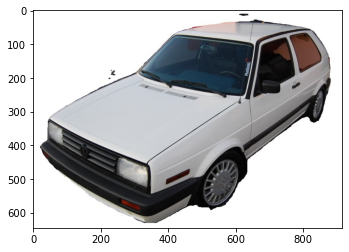

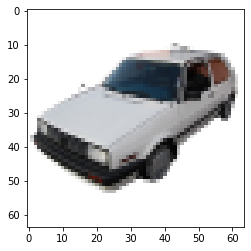

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
filtered_00881.jpg
render elevation is 15
pose elevation is 15


In [9]:
IMG_ID = -4
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

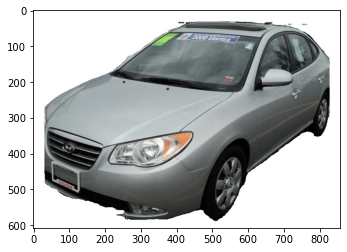

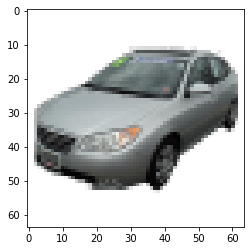

filtered_00376.jpg
render elevation is 15
pose elevation is 15


In [15]:
IMG_ID = -1
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

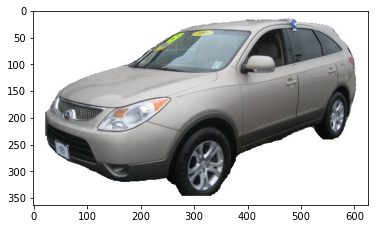

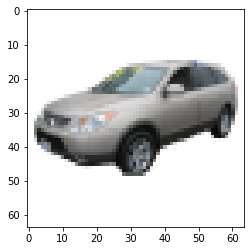

filtered_00034.jpg
render elevation is 15
pose elevation is 15


In [10]:
IMG_ID = -3
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

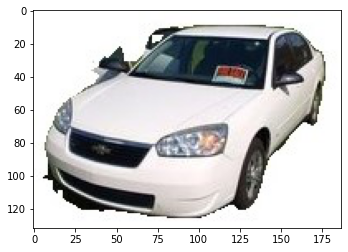

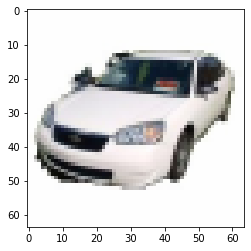

filtered_00018.jpg
render elevation is 15
pose elevation is 15


In [11]:
IMG_ID = -2
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

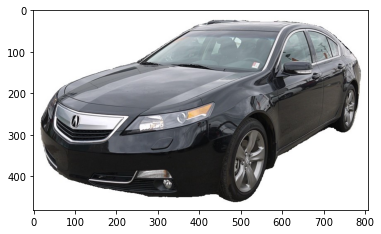

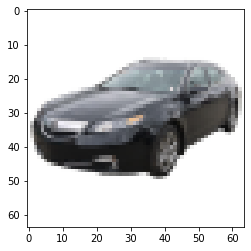

filtered_00002.jpg
render elevation is 15
pose elevation is 15


In [12]:
IMG_ID = -1
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

Define render poses and carry out actual renderings

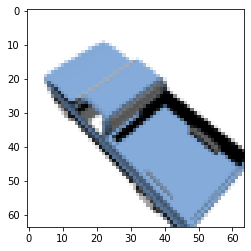

200000_ground_truth_val.png
render elevation is 30
pose elevation is 50


In [68]:
plt.imshow(images[0])
plt.show()
show_rendering(30,50, img_name=img_names[IMG_ID])

# -6.810337305068969727e-01 6.217651963233947754e-01 -3.867827951908111572e-01 -3.867829144001007080e-01
# -7.322519421577453613e-01 -5.782750248908996582e-01 3.597289621829986572e-01 3.597287535667419434e-01
# 1.011742511991542415e-07 5.282100439071655273e-01 8.491137027740478516e-01 8.491137623786926270e-01
# 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00 1.000000000000000000e+00

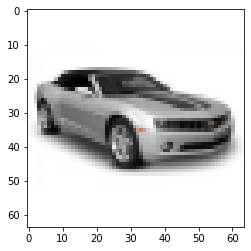

00076.jpg
render elevation is 15
pose elevation is 15


In [76]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

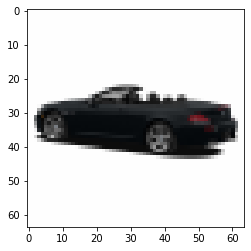

00022.jpg
render elevation is 15
pose elevation is 15


In [74]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

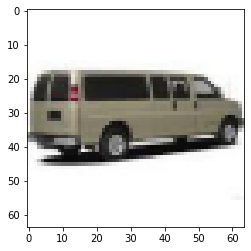

00169.jpg
render elevation is 15
pose elevation is 15


In [78]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

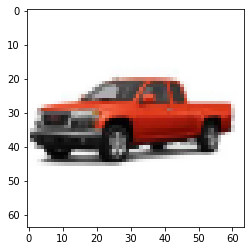

00178.jpg
render elevation is 15
pose elevation is 15


In [80]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

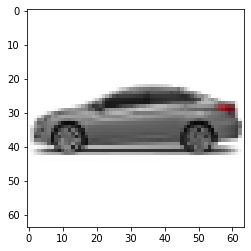

00472.jpg
render elevation is 15
pose elevation is 15


In [82]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

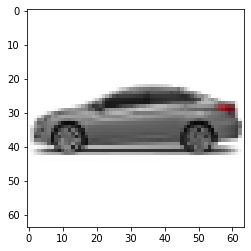

00472.jpg
render elevation is 0
pose elevation is 0


In [83]:
plt.imshow(images[0])
plt.show()
show_rendering(0,0, img_name=img_names[IMG_ID])

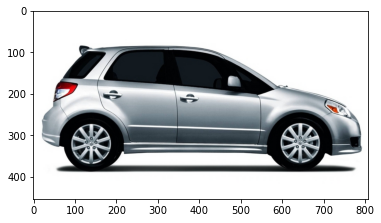

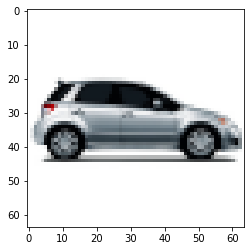

00475.jpg
render elevation is 0
pose elevation is 0


In [87]:
IMG_ID = 9
images = load_images(IMG_ID)
show_rendering(0,0, img_name=img_names[IMG_ID])

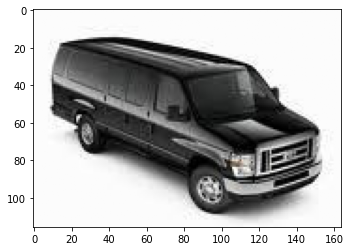

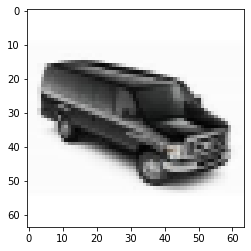

00949.jpg
render elevation is 45
pose elevation is 45


In [92]:
IMG_ID = 17
images = load_images(IMG_ID)
show_rendering(45,45, img_name=img_names[IMG_ID])

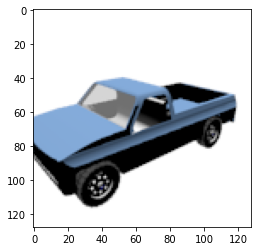

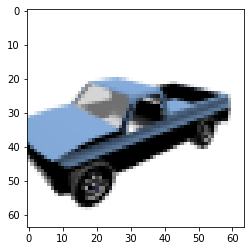

blender-005643.color.png
render elevation is 50
pose elevation is 50


In [99]:
IMG_ID = 18
images = load_images(IMG_ID)
show_rendering(50,50, img_name=img_names[IMG_ID])

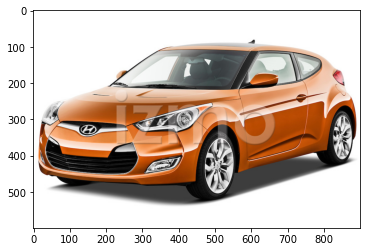

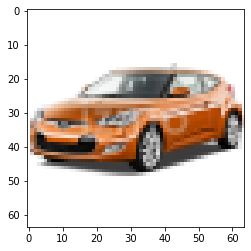

00563.jpg
render elevation is 30
pose elevation is 30


In [98]:
IMG_ID = 15
images = load_images(IMG_ID)
show_rendering(30,30, img_name=img_names[IMG_ID])

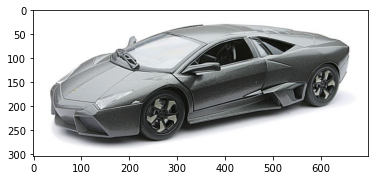

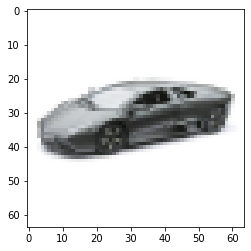

01066.jpg
render elevation is 15
pose elevation is 15


In [100]:
IMG_ID = 14
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

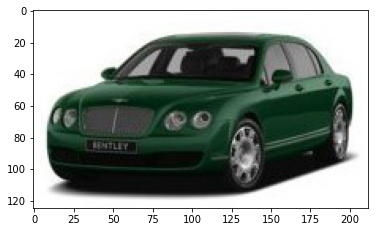

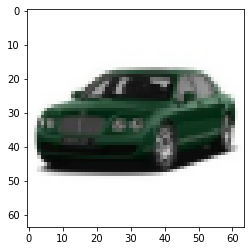

00896.jpg
render elevation is 15
pose elevation is 15


In [101]:
IMG_ID = 16
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])